This is the driver program for the ARIMA process. 

- It starts with testing stationarity.
- Then it runs a grid search for the best parameters. It returns the best parameters and we use those going forward.
- Then we summarize residual errors for the model.
- Then we summarize residual errors from bias corrected forecasts.
- Plots test vs prediction scores
- Saves finalized model to file
- Loads the finalized model and makes a prediction. This proves that it works.
- Then finally we forecast for the balance of the year.

Update the John Holkins, Covid-19 data https://github.com/CSSEGISandData/COVID-19 by refreshing your local copy of the GitHub repository. 

In [8]:
# import libraries
import numpy as np
import pandas as pd
import pickle
import stationarity as st
import load_data as ld
import arima_grid_search as ags
import summarize
import test_prediction_save_forecast_1day as tpsf1
import multi_step_forecast as msf

In [9]:
# Prepare arguments for driver
arg_dict = {'file_name_1': r'data\all_df.csv',
            'file_name_2': r'C:\Users\linds\OneDrive\mystuff\GitHub\covid\data\country_codes_edited.csv',
            'feature': 'Alpha_3',
            'place': 'USA',
            'dependent_variable': 'Confirmed',
            'path': r'C:\Users\linds\OneDrive\mystuff\GitHub\COVID-19\csse_covid_19_data\csse_covid_19_daily_reports',
            'best_cfg': (1,1,0), # I initially tried p,d,q of 7,2,0 based on the ACF and PACF. It did not converge.
            'p_values': range(0,3),
            'd_values': range(0,3),
            'q_values': range(0,3),
            'split_value': .5,
            'bias': 0, # First time thru bias is 0
            'date': '12-31-2020'}

The "data date" is 2020-06-29 00:00:00

ADF Statistic: -0.718251
p-value: 0.841965
Critical Values:
	1%: -3.476
	5%: -2.882
	10%: -2.578


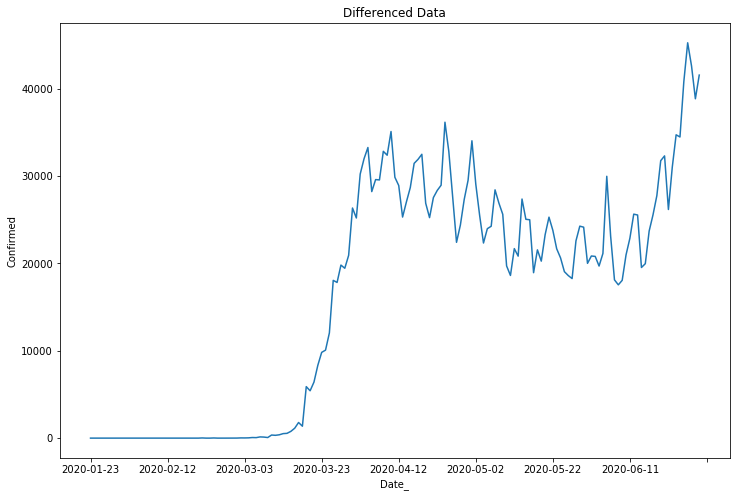

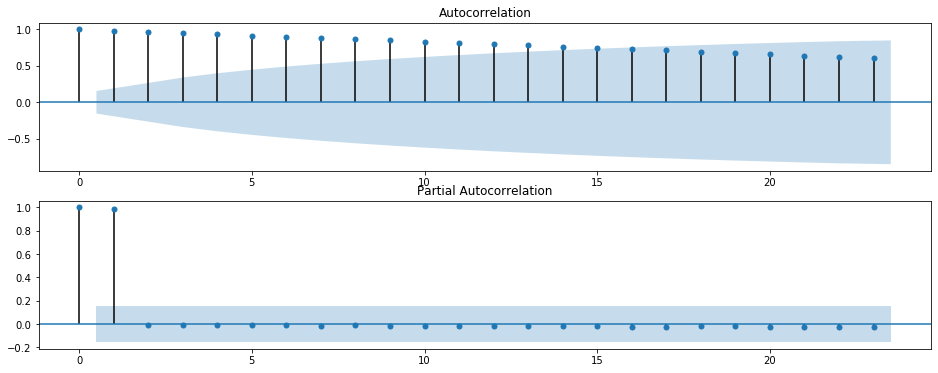

ARIMA(0, 0, 1) RMSE=824370.892
ARIMA(0, 1, 1) RMSE=14987.184
ARIMA(0, 2, 1) RMSE=3450.446
ARIMA(0, 2, 2) RMSE=3540.684
ARIMA(1, 0, 0) RMSE=26948.904
ARIMA(1, 1, 0) RMSE=3434.654
ARIMA(1, 2, 0) RMSE=3458.310
ARIMA(1, 2, 2) RMSE=3473.626
ARIMA(2, 1, 0) RMSE=3475.337
ARIMA(2, 2, 0) RMSE=3528.897
Best ARIMA(1, 1, 0) RMSE=3434.654
RMSE: 3434.654
       Residual Statistics
count            80.000000
mean            255.503463
std            3446.747325
min           -6622.156041
25%           -1617.866183
50%             509.449994
75%            2528.594707
max            9021.175302


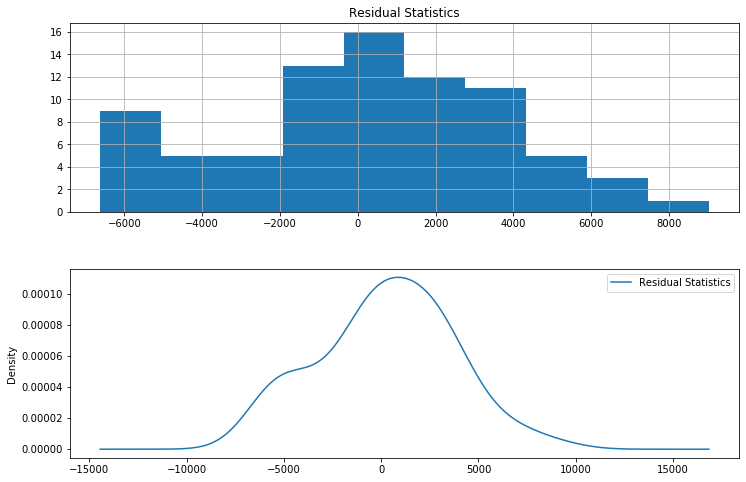


bias IS saved in arg_dict["bias"] for subsequent run is: 255.50346333929483 

RMSE: 3425.137
       Residual Statistics
count         8.000000e+01
mean         -4.511094e-11
std           3.446747e+03
min          -6.877660e+03
25%          -1.873370e+03
50%           2.539465e+02
75%           2.273091e+03
max           8.765672e+03


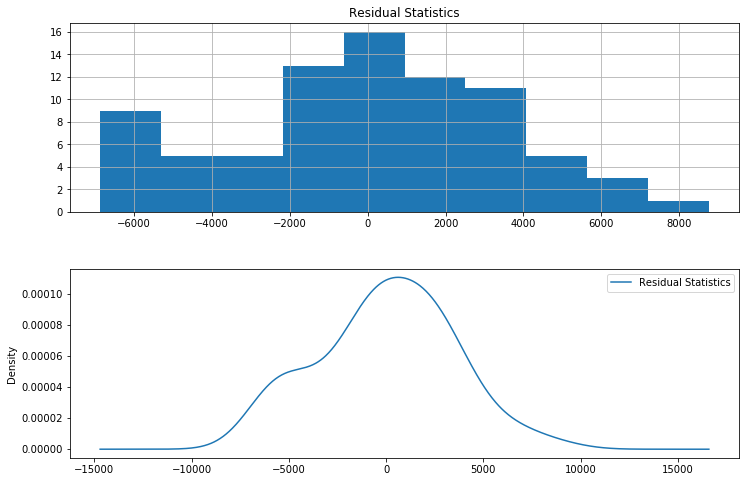


bias NOT saved in arg_dict["bias"] for subsequent run is: -4.511093720793724e-11 



In [10]:
# Load John Hopkins data
df, li_set = ld.driver(arg_dict)

# Get the date of the last row in the file to establish the currency of the data.
print(f'The "data date" is {df["Date_"].iloc[-1]}\n')

# save arg_dict for subsequent independent processing
with open('arg_dict.pickle', 'wb') as handle:
    pickle.dump(arg_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Test for stationarity
df = st.driver(arg_dict)

# save df for subsequent independent processing
df.to_csv('df.csv')
      
# Grid search ARIMA parameters 
best_cfg = ags.driver(df, arg_dict)
arg_dict.update({'best_cfg': best_cfg})

# summarize residual errors for an ARIMA model and return bias
model_fit, test, predictions = summarize.driver(df, arg_dict)

# Rerun summarize, as bias adjusted
model_fit, test, predictions = summarize.driver(df, arg_dict)
arg_dict.update({'test': test, 'predictions': predictions, 'model_fit': model_fit})

# save arg_dict for subsequent independent processing
with open('arg_dict.pickle', 'wb') as handle:
    pickle.dump(arg_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)


The predicted cumulative Confirmed for USA for tomorrow (input data plus 1 day) are 2,587,867


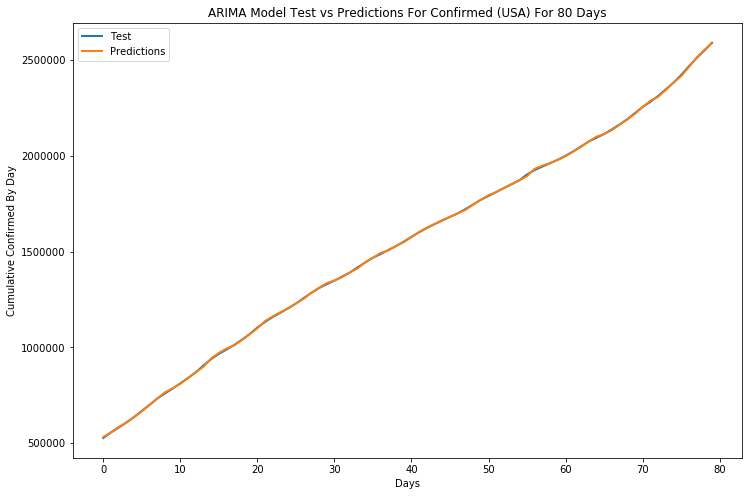

In [11]:
# Plot test (actual) vs predictions, save, and forecast
tpsf1.driver(arg_dict)

NB The above prediction of a single day in the future will only rarely match the the first day in the multi step forecast below. The reason is that the ARIMA model is a moving average model. The specific days included in the moving average change in the multi step forecast. 

The USA prediction is for 7,575,686 cumulative Confirmed to occur by 2020-12-31 00:00:00


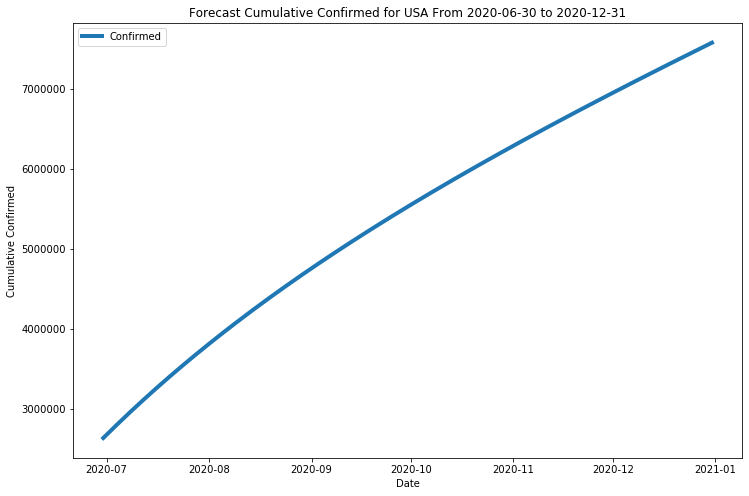

In [12]:
# Multi step forecast
df.index = pd.to_datetime(df.index)
forecast_df = msf.driver(df, arg_dict)

If the arg_dict has a prediction date later than the above date, the reason is that ARIMA expects the jurisdiction to have no more instances by the date indicated. We truncate the prediction at that point. 

In [13]:
new_col = "Daily_" + arg_dict['dependent_variable']
df[new_col] = df[arg_dict['dependent_variable']] - df[arg_dict['dependent_variable']].shift()
print('Actual')
df.tail() 

Actual


,Confirmed,Daily_Confirmed
Date_,,
2020-06-25,2422299.0,40806.0
2020-06-26,2467554.0,45255.0
2020-06-27,2510151.0,42597.0
2020-06-28,2548996.0,38845.0
2020-06-29,2590552.0,41556.0


In [14]:
forecast_df[new_col] = forecast_df[arg_dict['dependent_variable']] - forecast_df[arg_dict['dependent_variable']].shift()
forecast_df.iloc[0,1] = forecast_df.iloc[0,0] - df.iloc[-1,0]
print('Predicted')
forecast_df.head()

Predicted


,Confirmed,Daily_Confirmed
Date_,,
2020-06-30,2632053.0,41501.0
2020-07-01,2672993.0,40940.0
2020-07-02,2713632.0,40639.0
2020-07-03,2753973.0,40341.0
2020-07-04,2794020.0,40047.0
